In [511]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import numpy as np

plt.rcParams["font.family"] = "serif"


# Summary

# a. INPUT FILE
Load input file

# b. FILTER SIGNAL
Bandpass filter 100 Hz - 999 Hz.

# c. DETECT SPIKES
i. Apply Nonlinear Energy Operator to data.

ii. Apply amplitude threshold of 0.0045.

iii. Find spike starts, exclude spikes within 23 samples of the previous spike.

iv. Find spike peaks by finding local maximum of spike starts.

# d. ALIGN SPIKES
Align spikes by spike peaks with a window of -5 to 15 samples.

# e. EXTRACT FEATURES
PCA with 2 components. Explains about 70% of the variance.

# f. CLUSTER SPIKES

i. Try K-Means clustering. Find optimal K with elbow curve. Analyze.
ii. Try agglomerative clustering. Find optimal K.
iii. Continue with agglomerative clustering.

# g. CLASSIFY SPIKES
Color-code spike alignment and raw data.

# a. INPUT FILE

In [512]:
M = np.loadtxt("EMG_example_20s_2000Hz-2022.csv", delimiter=",", dtype=float) # read csv

channel_1 = M[:, 0] 
channel_2 = M[:, 1]
fs = 2000

print(f'The shape of the file is {M.shape} with sampling rate {fs} Hz.')

The shape of the file is (40001, 2) with sampling rate 2000 Hz.


# b. FILTER SIGNAL

In this section, we apply a bandpass filter from 100 Hz to 999 Hz, which is the maximum we can apply. This removes low-frequency noise and centers the data at y = 0. In general, 100 Hz is too low to include many spikes, so it is safe to apply.

In [513]:
# Takes raw data, returns bandpass filtered data.
def bandpass_filter(data, low_freq, high_freq, sampling_rate, steepness = 3):

	sos = sig.butter(steepness, [low_freq * 2/sampling_rate, high_freq * 2/sampling_rate], btype = "bandpass", output = "sos")
	filt_data = sig.sosfilt(sos, data)

	return filt_data

Text(0.5, 1.0, 'Raw Data')

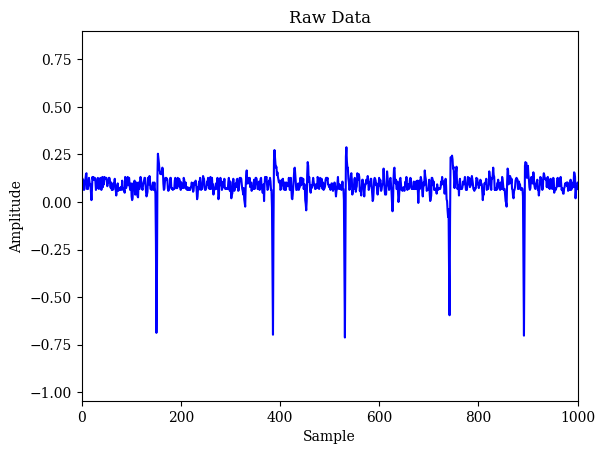

In [514]:
# Plots the first 1000 data points of the unfiltered data.
plt.plot(channel_2, color='blue')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.xlim(0, 1000)
plt.title('Raw Data')

<Figure size 640x480 with 0 Axes>

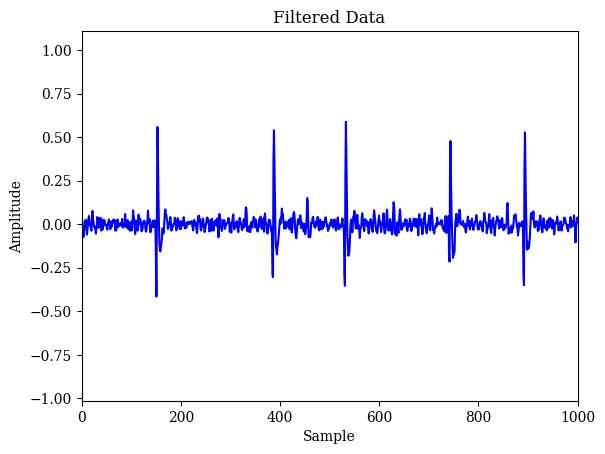

<Figure size 640x480 with 0 Axes>

In [515]:
filt_data = bandpass_filter(channel_2, 100, 999, sampling_rate=fs)
plt.plot(filt_data, color='blue')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.xlim(0, 1000)
plt.title('Filtered Data')
plt.figure()

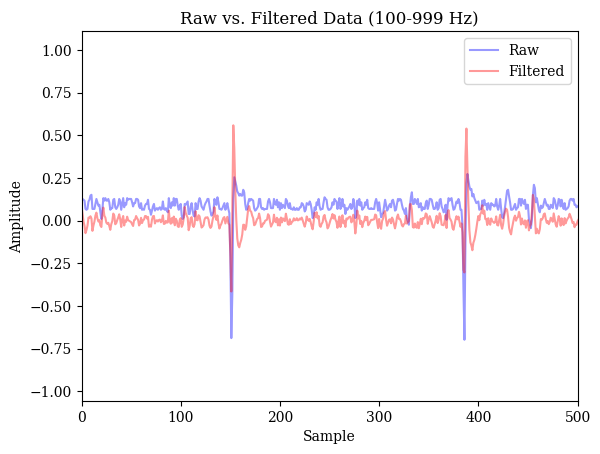

In [516]:

# This chart compares the filtered and unfiltered data. The filtered data is centered at y = 0 now.

plt.plot(channel_2, color='blue', alpha=0.4, label='Raw')
plt.plot(filt_data, color='red', alpha=0.4, label='Filtered')
plt.xlim(0, 500)
plt.ylabel('Amplitude')
plt.xlabel('Sample')
plt.title('Raw vs. Filtered Data (100-999 Hz)')
plt.legend()

# c. DETECT SPIKES

In this section, we apply the nonlinear energy operator to the data. This emphasizes high-frequency portions of the data, making spikes more salient. It also removes a lot of the negative parts of the data to allow us to apply a positive amplitude threshold. 

Text(0.5, 1.0, 'NEO vs. Filtered Data')

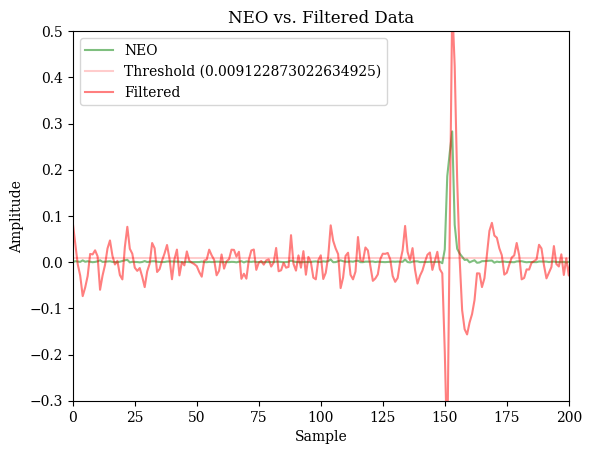

In [517]:
#threshold = 0.01


# Applies the Nonlinear Energy Operator to the data: x(t)^2 - x(t-1)x(t+1).
def NEO(data):
    neo_arr = []
    neo_arr.append(0)
    for i in range(1, len(data) - 1):
        neo_i = data[i]**2 - data[i-1]*data[i+1]
        neo_arr.append(neo_i)
    neo_arr.append(0)

    return neo_arr


# Plot the FFT data and NEO data.
neo_arr = np.array(NEO(filt_data))
plt.plot(neo_arr, alpha=0.5, label='NEO', color='green')
plt.axhline(y = threshold, color='r', linestyle='-', alpha=0.2, label='Threshold ('+str(threshold) + ')')
plt.xlim(0, 200)
plt.plot(filt_data, alpha=0.5, label='Filtered', color='red')
plt.ylim(-0.3, 0.5)
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('NEO vs. Filtered Data')

This cell calculates the threshold. We first take the histogram of the data and find the point that is 2% of the peak. The 2% was chosen by trial-and-error.

Text(0, 0.5, 'Frequency')

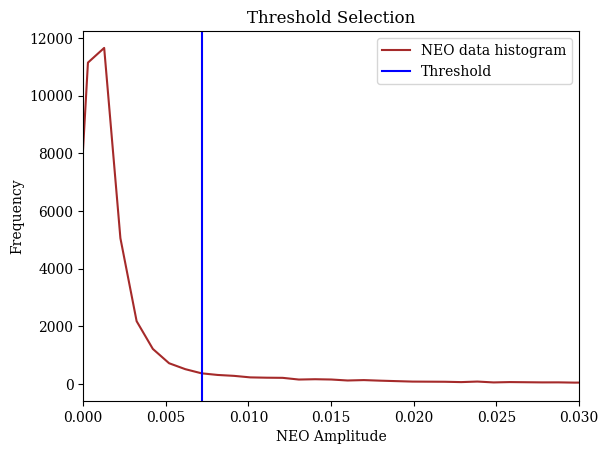

In [537]:
frequency, bins = np.histogram(neo_arr, bins=1000)
plt.plot(bins[1:], frequency, label='NEO data histogram', color='brown')
plt.xlim(0, 0.03)
max_val = np.max(frequency)
t = bins[np.where(frequency <= 0.03*max_val)]
threshold = t[np.where(t > 0)][0]
plt.axvline(x = threshold, label='Threshold', color='blue')
plt.legend()
plt.title('Threshold Selection')
plt.xlabel('NEO Amplitude')
plt.ylabel('Frequency')

In [538]:
# The threshold indices are found by collecting the points where the NEO data is greater than
# or equal to the threshold.
threshold_indices = np.where(neo_arr >= threshold)[0]

The spike length was chosen to be 20 data points. This value represents the delay between spikes to avoid counting one spike multiple times. Ideally, it will be short enough to include spikes firing in close proximinty, while long enough to avoid double-counting the same spike.

In [539]:

spike_length = 20

### This script finds the indices of the beginning of each spike. It includes most of the threshold indices
### while excluding some of the indices that fall within one spike length of an index.
spike_starts = [threshold_indices[0]]
for i in range(1, len(threshold_indices)):
    spike_time = threshold_indices[i]
    if spike_time - spike_starts[-1] > spike_length:
        spike_starts.append(spike_time)



### This script finds the peaks of each spike. Within a radius of one spike length, it finds the peak of the data.
spike_peaks = []
for i in range(0, len(spike_starts)):
    spike_start = spike_starts[i]
    spike_max = spike_start + np.argmax(neo_arr[spike_start: spike_start+spike_length])
    spike_min = spike_start + np.argmin(neo_arr[spike_start: spike_start+spike_length])
    if neo_arr[spike_max] > np.abs(neo_arr[spike_min]):
        spike_peaks.append(spike_max)
    else:
        spike_peaks.append(spike_min)

#print(spike_peaks)
#print(len(spike_peaks))
#print(np.argmin(filt_data[155: 165]) + 155)
print(f'Found {len(spike_peaks)} spike peaks!')

Found 641 spike peaks!


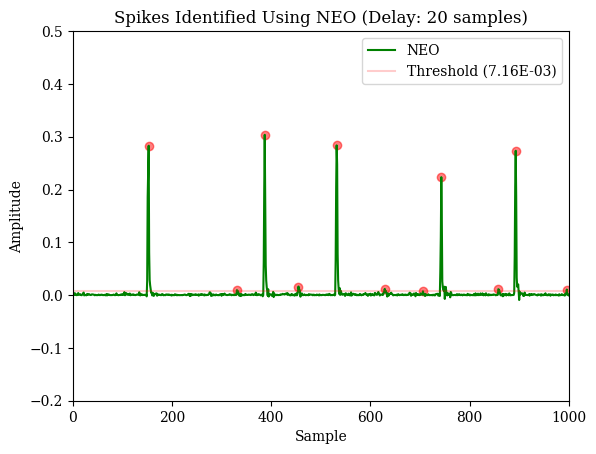

In [541]:

plt.plot(neo_arr, label='NEO', color='green')
for i in range(len(spike_peaks)):
    x = spike_peaks[i]
    y = neo_arr[x]
    plt.scatter(x, y, color='red', alpha=0.5)
plt.axhline(y = threshold, color='r', linestyle='-', alpha=0.2, label=f'Threshold ({threshold:.2E})')
plt.xlim(0, 1000)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.ylim(-0.2, 0.5)
plt.title('Spikes Identified Using NEO (Delay: ' + str(spike_length) + ' samples)')
plt.legend()

# d. ALIGN SPIKES

This section aligns the spikes with a window of 5 samples to the left and 15 samples to the right. Those values were chosen through trial-and-error to include as much of the information from the spike as possible while not including noise or the next spike. The spikes are aligned by the spike peak indices found in the previous section.

One spike occurs at such a position where a -5 to 15 window is not available, so it cannot fit into the model. To solve this, we just append zeros until it fits. Otherwise, excluding it would screw up the future indexing.

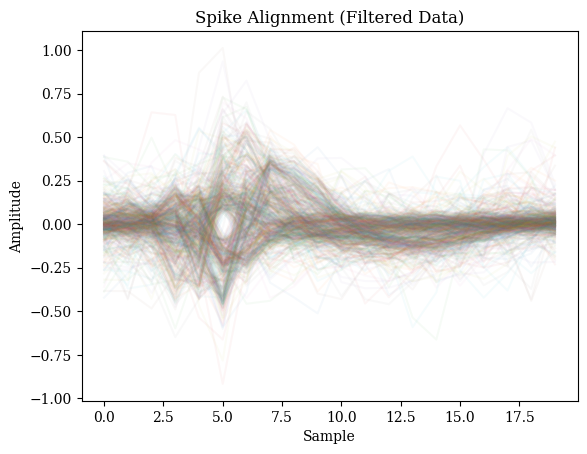

In [542]:
left_window = 5
right_window = 15

matrix = []

for i in range(len(spike_peaks)):
    spike_idx = spike_peaks[i]
    chunk = filt_data[spike_idx-left_window:spike_idx+right_window]

    # If the chunk is too short, add zeros.
    while len(chunk) < right_window + left_window:
        chunk = np.append(chunk, 0)
    matrix.append(chunk)
    plt.plot(chunk, alpha=0.04)

plt.title('Spike Alignment (Filtered Data)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

matrix = np.array(matrix)

In [543]:
from sklearn.decomposition import PCA

print(f' We found {matrix.shape[0]} spikes and saved {matrix.shape[1]} data points per spike.')

 We found 641 spikes and saved 20 data points per spike.


# e. EXTRACT FEATURES

This section uses 2-component PCA to compress the spike data from dimensions to 2 dimensions with the intention to cluster. It's clear that a few clusters appear. I would select 5 clusters (top left, top right, center, bottom left, bottom right).

The two components account for about 70% of the variance, which indicates that the data is compressed without very much loss of information.

<Figure size 640x480 with 0 Axes>

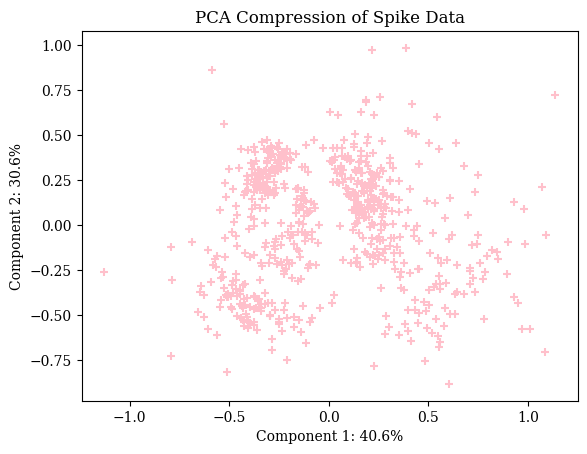

<Figure size 640x480 with 0 Axes>

In [544]:
pca = PCA(n_components=2)
matrix_new = pca.fit_transform(matrix, y=None)
a, b = pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]
plt.scatter(matrix_new[:, 0], matrix_new[:, 1], color='pink', marker='+')
plt.title('PCA Compression of Spike Data')
plt.xlabel(f'Component 1: {a*100:.3}%')
plt.ylabel(f'Component 2: {b*100:.3}%')
plt.figure()

# f. CLUSTER SPIKES

We investigate K-Means clustering and agglomerative clustering.

In [545]:
from sklearn.cluster import KMeans

from sklearn.cluster import AgglomerativeClustering

For k-means clustering, we cannot arbitrarily decide k since each dataset will have a different number of neurons. 

We use the elbow method, which finds the k at the inflection point of the inertia vs. k graph. Inertia is the sum of squared distances, which represents how close the average point is to its center. Of course, the points will be closer on average if there are more k values, so we look for the elbow point that balances the number of clusters with the inertia.

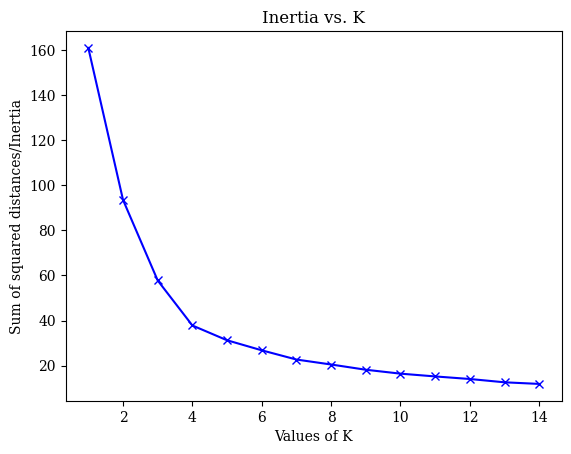

In [546]:
Sum_of_squared_distances = []
percent_drops = []

K = range(1,15)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, n_init=4)
    kmeans.fit(matrix_new)
    Sum_of_squared_distances.append(kmeans.inertia_)

for i in range(1, len(Sum_of_squared_distances)):
    percent_drops.append(100 - Sum_of_squared_distances[i]/Sum_of_squared_distances[i-1]*100)
plt.plot(K,Sum_of_squared_distances,'bx-')

plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Inertia vs. K')
plt.show()

To objectively find an optimal K value, we create a function from the data points and find the second derivative function. The peak of the second derivative function is where the inflection point lies. That value is our optimal k.

According to the elbow graph, the optimal value of K is 2.


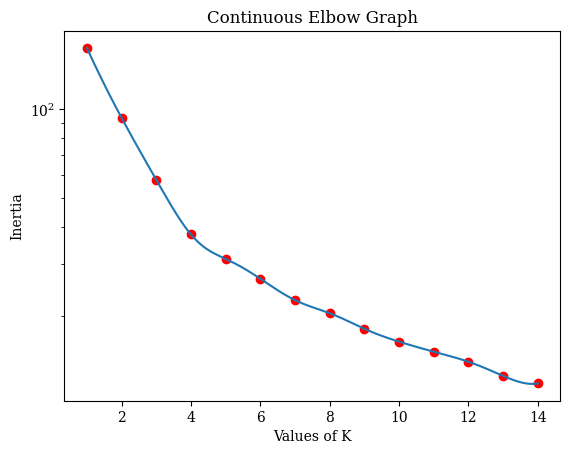

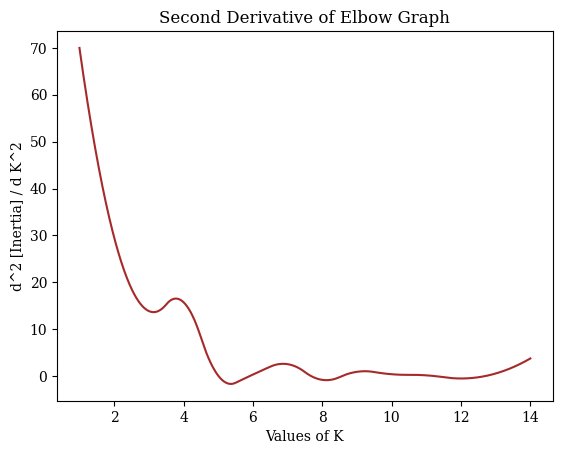

In [547]:
from scipy.interpolate import UnivariateSpline

x = K
y = Sum_of_squared_distances
#print(x.size, y.size)
y_spl = UnivariateSpline(x,y,s=0,k=4)

plt.semilogy(x,y,'ro',label = 'data')
x_range = np.linspace(x[0],x[-1],1000)
plt.semilogy(x_range,y_spl(x_range))
plt.title('Continuous Elbow Graph')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.figure()


y_spl_2d = y_spl.derivative(n=2)

plt.plot(x_range,y_spl_2d(x_range), color='brown')
plt.title('Second Derivative of Elbow Graph')
plt.xlabel('Values of K')
plt.ylabel('d^2 [Inertia] / d K^2')
optimal_k = int(x_range[np.argmax(y_spl_2d(x_range))]) + 1
print(f'According to the elbow graph, the optimal value of K is {optimal_k}.')

/Users/martinbourdev/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0, 0.5, 'PC 2')

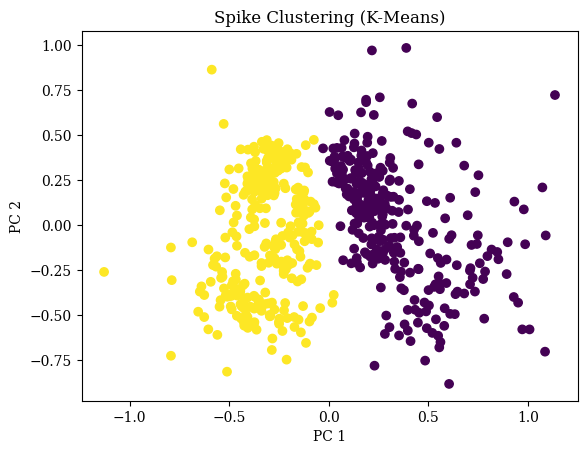

In [548]:
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(matrix_new)

plt.scatter(matrix_new[:, 0], matrix_new[:, 1], c=kmeans.labels_)
plt.title('Spike Clustering (K-Means)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

This clustering is unacceptable. We want a clustering as close as possible to the one we speculated by eyeballing the PCA chart. This method only chooses 3 clusters when we wanted 5. Not only that, it cuts our center and top-right clusters in half. It also groups together our top-right, center, and top-left clusters into one. This will not do.

The limits of K-Means clustering require that the boundaries are straight lines, which may not work well for this data. To address this, we are going to try agglomerative clustering.

## Agglomerative Clustering

AC works bottom-up, by finding the closest points and joining them into a cluster. It then joins the closest clusters until the ideal number of clusters is reached. We can visualize it with a dendrogram.

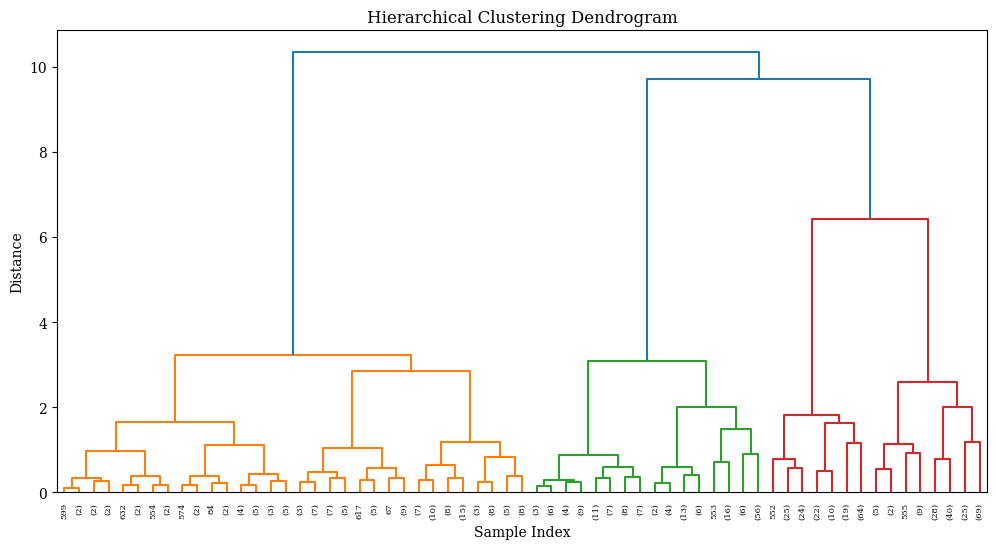

In [549]:
from scipy.cluster.hierarchy import dendrogram, linkage

Sum_of_squared_distances = []
percent_drops = []

agg_cluster = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0)
agg_cluster.fit(matrix_new)

linkage_matrix = linkage(matrix_new, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram_data = dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Adjust the 'p' parameter for a clear view
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


How do we find the ideal value of K? A natural choice seems to be to look at the distances between each new cluster. If the distances are close, then the distinction is more arbitrary. Below, we plot the chart of the y-distance coordinate of the dendrogram (and reverse it).

If you look at the dendrogram top-down (splitting one cluster into many), you can see the logic. After splitting into two clusters, the distance to the third cluster is small, indicating a weaker split. Then, the distance to create the third cluster is fairly large, as is the distance to create the fourth cluster. Then, the clusters split very quickly. Therefore, just by eyeballing the graph, we would probably want 3 or 4 clusters.

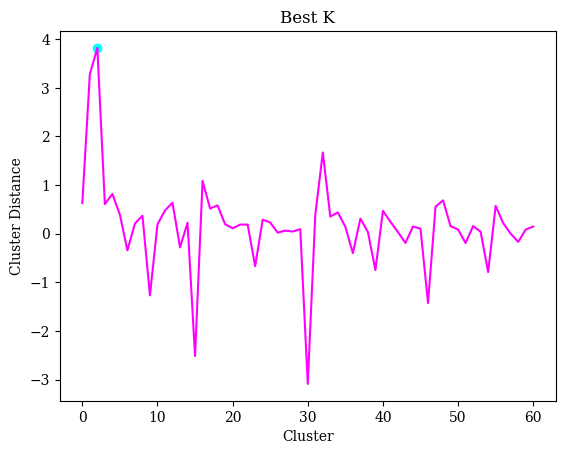

In [550]:
y_values = np.array(dendrogram_data['dcoord'])[:, 1]
y_distances = np.diff(y_values)[::-1]
peak = np.argmax(y_distances)

# Finds the largest k value where the y value is within 20% of the peak.
max_K = 8
best_K = np.where(y_distances[:max_K] >= 0.2*np.max(y_values))[0][-1] + 2 # Add two because the function starts at 2 clusters, not 0.

plt.plot(y_distances, color='magenta')
plt.xlabel('Cluster')
plt.ylabel('Cluster Distance')
plt.title('Best K')
plt.scatter(best_K-2, y_distances[best_K-2], color='cyan')

We can see that, indeed, the distance to the third and fourth clusters is high. One subtlety is that we don't just find the maximum of the function, but find the largest cluster value where the distance is within 80% of the maximum. In other words, if the peak happened to be at 3 clusters instead of 4, the function would still choose 4.

That is because we want to err on the side of having more clusters. It's better for any kind of future data analysis to split one neuron into two than to combine two neurons into one.

Text(0, 0.5, 'Component 2')

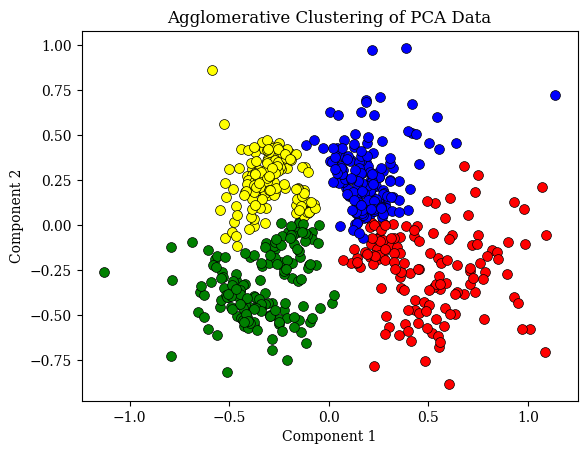

In [556]:
agg_cluster = AgglomerativeClustering(n_clusters=best_K, linkage='ward', metric='euclidean')
agg_cluster.fit(matrix_new)

plt.figure()
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'brown']
for i in range(len(matrix_new)):
    plt.scatter(matrix_new[i, 0], matrix_new[i, 1], color=colors[agg_cluster.labels_[i]], s=50, edgecolors='k', linewidth=0.5)
plt.title('Agglomerative Clustering of PCA Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

I wish the algorithm chose 5 clusters instead of 4, but we have to trust it. We can however immediately see that agglomerative clustering did better than k-means clustering. I would split the red cluster into two, but other than that it works.

# g. CLASSIFY SPIKES

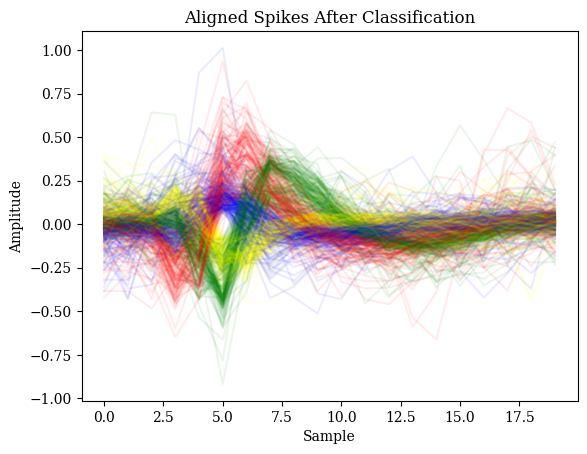

In [552]:

matrix = []
new_spike_peaks = []
avg_chunks = [[] for _ in range(5)]

idx = 0
for i in range(len(spike_peaks)):
    spike_idx = spike_peaks[i]
    chunk = filt_data[spike_idx-left_window:spike_idx+right_window]
    if len(chunk) == right_window + left_window:
        matrix.append(chunk)
        label_idx = agg_cluster.labels_[idx]
        avg_chunks[label_idx].append(chunk)
        plt.plot(chunk, alpha=0.08, color=colors[label_idx])
        idx += 1
        new_spike_peaks.append(spike_idx)


#for i in range(len(avg_chunks)):
#   plt.plot(np.mean(avg_chunks[i], axis=0), color=colors[i], linewidth=3, alpha=0.7)

plt.title('Aligned Spikes After Classification')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

matrix = np.array(matrix)

# h. ANALYSIS

The chart above shows the spike alignment, color-coded by classified spike. It looks pretty good. One thing to note is that the red and blue spikes may be from the same neuron, with an error in spike alignment.

/Users/martinbourdev/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/martinbourdev/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


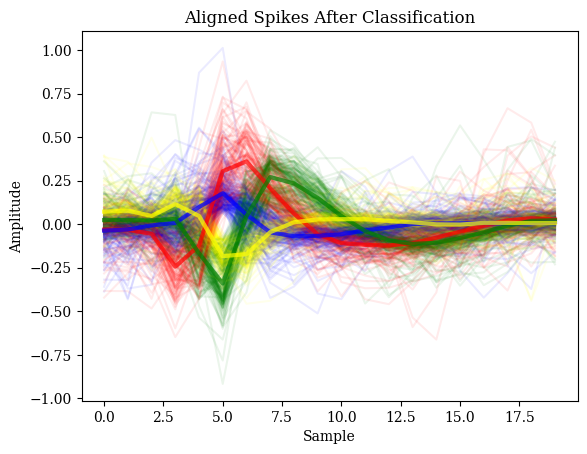

In [553]:

matrix = []
new_spike_peaks = []
avg_chunks = [[] for _ in range(5)]

idx = 0
for i in range(len(spike_peaks)):
    spike_idx = spike_peaks[i]
    chunk = filt_data[spike_idx-left_window:spike_idx+right_window]
    if len(chunk) == right_window + left_window:
        matrix.append(chunk)
        label_idx = agg_cluster.labels_[idx]
        avg_chunks[label_idx].append(chunk)
        plt.plot(chunk, alpha=0.08, color=colors[label_idx])
        idx += 1
        new_spike_peaks.append(spike_idx)


for i in range(len(avg_chunks)):
   plt.plot(np.mean(avg_chunks[i], axis=0), color=colors[i], linewidth=3, alpha=0.7)

plt.title('Aligned Spikes After Classification')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

matrix = np.array(matrix)

The chart above is the same, but with the averages drawn on it. Again, the blue and red appear suspiciously similar. This plot shows the filtered data, and the PCA is performed on the filtered data, but the spike peaks are found using the NEO data. This overall algorithm is unfortunately highly dependent on alignment.

641

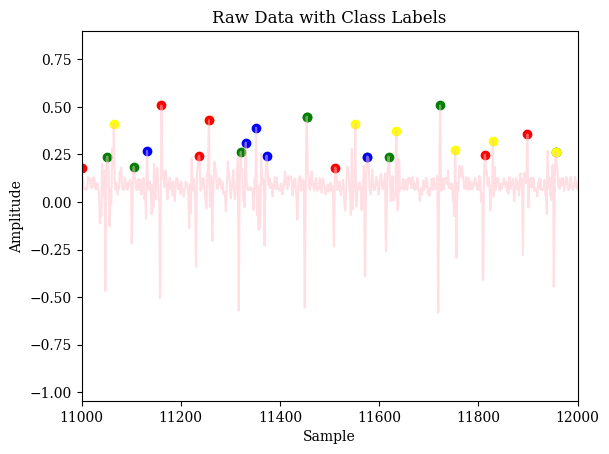

In [573]:
plt.plot(channel_2, color='pink', alpha=0.5)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
x = 11
plt.xlim(1000*x, 1000*(x+1))
plt.title('Raw Data with Class Labels')

#label_colors = []
#for i in range(len(spike_peaks)):
#    label_colors.append(colors[agg_cluster.labels_[i]])
#plt.scatter(spike_peaks, channel_2[spike_peaks], c=label_colors)

for i in range(len(spike_peaks)):
    color = colors[agg_cluster.labels_[i]]
    raw_spike_peak = np.argmax(channel_2[spike_peaks[i]-10:spike_peaks[i]+10]) - 10 + spike_peaks[i]
    plt.scatter(raw_spike_peak, channel_2[raw_spike_peak], c=color)

len(spike_peaks)
len(agg_cluster.labels_)

This chart depicts the raw data with colored labels. There are some possible spikes that get missed due to the spike delay or the threshold.